In [1]:
import pandas 

import matplotlib.pyplot
import seaborn

from scipy.stats import ranksums

from newCentrality_v4 import parse_interactome, parse_causal_genes

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


#### Load and parse the necessary data

In [2]:
PHENOTYPE = "MMAF"

In [3]:
interactome, genes = parse_interactome(interactome_file="data/Interactome_human.sif")

causal_genes = parse_causal_genes(causal_genes_file="data/causalGenes_allPhenotypes.csv",
                                  canonical_genes_file="data/canonicalGenes.tsv",
                                  genes=genes)

In [4]:
# load scores
scores = {}

with open(f"scores.tsv", 'r') as f:
    # skip header
    next(f)

    data = f.read().splitlines()
    for line in data:
        line_splitted = line.split('\t')
        gene, score = line_splitted
        # skip causal genes
        if causal_genes.get(gene) == 1:
            continue
        scores[gene] = float(score)

In [5]:
# load scores for d=10
scores_d10 = {}

with open(f"scores_d10.tsv", 'r') as f:
    # skip header
    next(f)

    data = f.read().splitlines()
    for line in data:
        line_splitted = line.split('\t')
        gene, score = line_splitted
        # skip causal genes
        if causal_genes.get(gene) == 1:
            continue
        scores_d10[gene] = float(score)

#### Analyze leave-one-out results: newCentrality_v4.py

In [6]:
# load left-out scores
scores_left_out = {}

with open(f"leave_one_out/left_out_scores.tsv", 'r') as f:
    # skip header
    next(f)

    data = f.read().splitlines()
    for line in data:
        line_splitted = line.split('\t')
        gene, score = line_splitted
        scores_left_out[gene] = float(score)

In [7]:
# load left-out scores for d=10
scores_left_out_d10 = {}

with open(f"leave_one_out_d10/left_out_scores.tsv", 'r') as f:
    # skip header
    next(f)

    data = f.read().splitlines()
    for line in data:
        line_splitted = line.split('\t')
        gene, score = line_splitted
        scores_left_out_d10[gene] = float(score)

#### Analyze leave-one-out results: pageRankCentrality.py

In [31]:
# load left-out scores
scores_left_out = {}

with open(f"leave_one_out_pageRank/left_out_scores.tsv", 'r') as f:
    # skip header
    next(f)

    data = f.read().splitlines()
    for line in data:
        line_splitted = line.split('\t')
        gene, score = line_splitted
        scores_left_out[gene] = float(score)

#### Analyze degree centrality

In [7]:
# load scores
scores_DC = {}

with open(f"scores_DC.tsv", 'r') as f:
    # skip header
    next(f)

    data = f.read().splitlines()
    for line in data:
        line_splitted = line.split('\t')
        gene, score = line_splitted
        # skip causal genes
        if causal_genes.get(gene) == 0:
            continue
        scores_DC[gene] = float(score)

#### Analyze betweenness centrality

In [8]:
# load scores
scores_BC = {}

with open(f"scores_BC.tsv", 'r') as f:
    # skip header
    next(f)

    data = f.read().splitlines()
    for line in data:
        line_splitted = line.split('\t')
        gene, score = line_splitted
        # skip causal genes
        if causal_genes.get(gene) == 0:
            continue
        scores_BC[gene] = float(score)

#### Plot

In [12]:
df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
df_scores['group'] = "non-causal"

df_scores_d10 = pandas.DataFrame.from_dict(scores_d10, 
                                       orient='index', 
                                       columns=['score'])
df_scores_d10['group'] = "non-causal d=10"

df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                orient='index', 
                                                columns=['score'])

df_scores_left_out['group'] = 'left-out'

df_scores_left_out_d10 = pandas.DataFrame.from_dict(scores_left_out_d10, 
                                                orient='index', 
                                                columns=['score'])

df_scores_left_out_d10['group'] = 'left-out d=10'

# # Add degree centrality
# df_DC = pandas.DataFrame.from_dict(scores_DC,
#                                    orient='index',
#                                    columns=['score'])

# df_DC['group'] = 'DC_causal'

# # Add betweenness centrality

# df_BC = pandas.DataFrame.from_dict(scores_BC,
#                                    orient='index',
#                                    columns=['score'])

# df_BC['group'] = 'BC_causal'


# concatenate dataframes for comparison
df_compare = pandas.concat([df_scores, df_scores_left_out, df_scores_d10, df_scores_left_out_d10])

In [16]:
stat, p_value = ranksums(df_scores['score'].values, df_scores_left_out['score'].values)
stat, p_value

(-2.3545816823386394, 0.01854356770720196)

In [14]:
stat, p_value = ranksums(df_scores_d10['score'].values, df_scores_left_out_d10['score'].values, alternative='less')
stat, p_value

(-1.3677313498703403, 0.08569809157479552)

(0.0, 0.01)

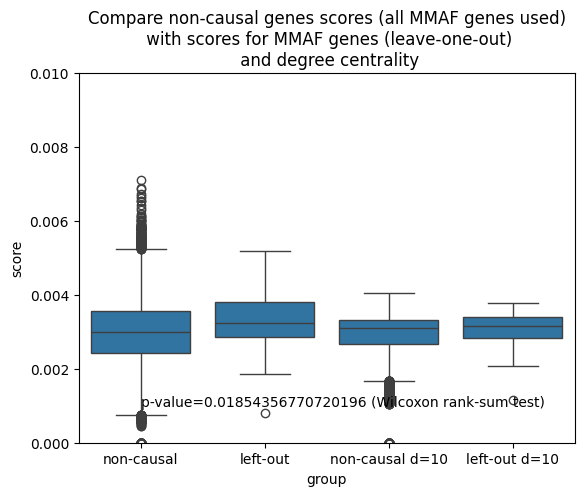

In [17]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\n and degree centrality")
matplotlib.pyplot.ylim(0, 0.01)